# Exploring Strava Runs: Analyzing a single activity

In this notebook, we're going to talk a look at how Strava activities (or the files created by similar sports tracking apps) can be analyzed with Python. Here, we'll get a first glance at how GPX files look like and what we can do with them. We'll later use this knowledge to create a script that analyzes all Strava activities and creates some interesting aggregated statistics.

In [1]:
import gpxpy

from format_data import format_gpx
from plot_helpers import plotting

Read the data:

In [2]:
file_id = '638693618'
gpx_file = open(f'data/activities/{file_id}.gpx', 'r')
gpx = gpxpy.parse(gpx_file)

Understanding the structure of the file:

In [3]:
print("{} track(s)".format(len(gpx.tracks)))
track = gpx.tracks[0]

print("{} segment(s)".format(len(track.segments)))
segment = track.segments[0]

print("{} point(s)".format(len(segment.points)))

1 track(s)
1 segment(s)
1994 point(s)


[This is the first run I ever recorded with Strava.](https://www.strava.com/activities/638693618) We can see that it consists of just a single track with a single segment, which itself contains a number of GPX points. Strava stores all activities in this format, so to analyze them, it's enough to loop over the GPX points. We'll create a data frame with the basic ingredients that interest us below:

In [4]:
f = format_gpx() # initialize
run1 = f.get_df_from_gpx(gpx)
run1.head()

,altitude,longitude,latitude,pace,time_of_day,time_zone,elapsed_time,distance,vertical_gain,vertical_loss,km,hour_of_day
0,525.6,11.689483,48.131937,0.976292,2016-07-12 19:13:58+02:00,Europe/Berlin,00:00:00,0.000000,0.0,0.0,1,19
1,525.7,11.689501,48.131806,1.813386,2016-07-12 19:14:13+02:00,Europe/Berlin,00:00:15,0.014628,0.1,0.0,1,19
2,525.6,11.689468,48.131815,3.444081,2016-07-12 19:14:14+02:00,Europe/Berlin,00:00:16,0.017273,0.1,0.1,1,19
3,525.2,11.689356,48.131829,4.310673,2016-07-12 19:14:16+02:00,Europe/Berlin,00:00:18,0.025730,0.1,0.5,1,19
4,525.0,11.689298,48.131822,3.904486,2016-07-12 19:14:17+02:00,Europe/Berlin,00:00:19,0.030104,0.1,0.7,1,19


We can plot the GPS coordinates on top of a screenshot from the run. This is done in a quick-and-dirty fashion, so it doesn't exactly overlap, but it shows that we correctly capture the information.

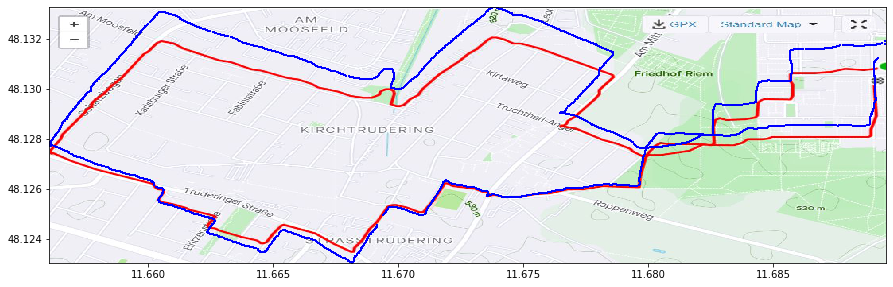

In [5]:
#Plot our data on top of strava's image (screenshot)
plotting.overlay_map(df = run1, img_loc = "data\\map_screenshot.jpg")

We can also take a first look at the plots for distance vs elevation and distance vs speed:

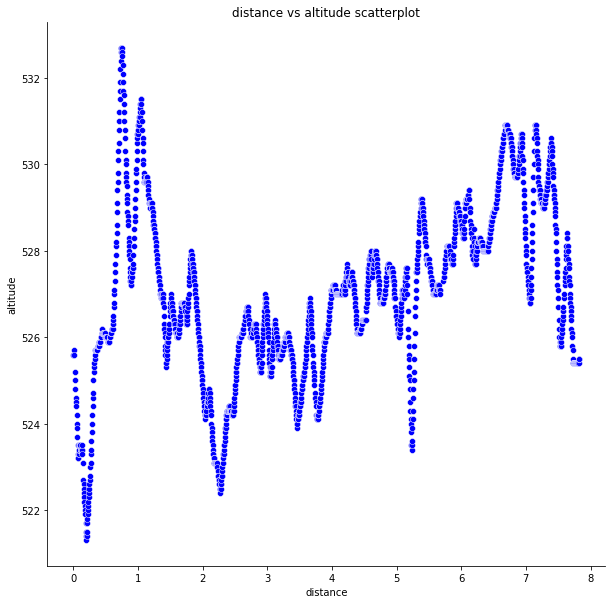

In [6]:
# Elevation scatter plot
plotting.single_scatter(run1, 'distance', 'altitude', 'blue')

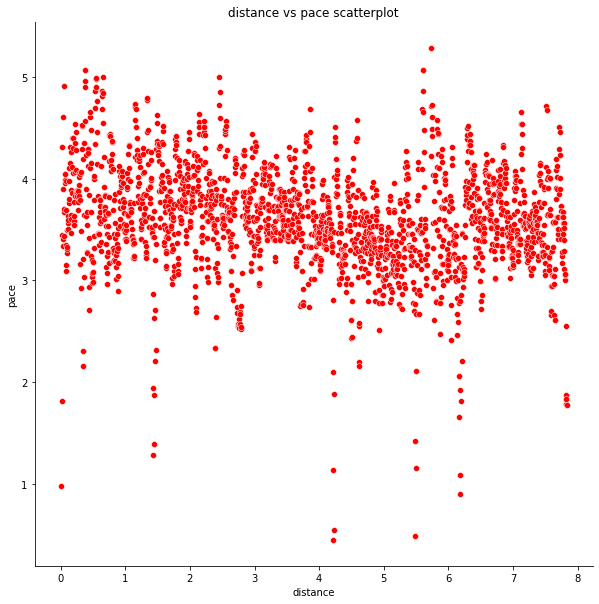

In [7]:
# Pace scatter plot
plotting.single_scatter(run1, 'distance', 'pace', 'red')

These look rather noisy, and we'll certainly have to do some more work on it. Let's do a quick sanity check to see how far off we are:

In [8]:
print(f"The total distance is {round(max(run1['distance']),2)}km "
      f"and the vertical gain is {round(max(run1['vertical_gain']),2)}m.")

The total distance is 7.83km and the vertical gain is 66.4m.


Comparing this to the results from Strava, we notice a very good agreement for the distance of (7.83km, essentially the same) but the elevation gain seems wildly off (66m vs 11m). Strava's estimate is much lower, presumably because of some "smoothing out" of the elevation profile. This makes sense - after all, we don't want to count every sidewalk or other unrelated noise (say, the movement of your arm if you carry a GPS watch).

We will thus add two columns to the data frame with a smooth version of both the elevation and the speed profile, using a Savitzky-Golay filter.

In [9]:
run_smooth = f.add_smooth_cols(run1)
run_smooth.head()

,altitude,longitude,latitude,pace,time_of_day,time_zone,elapsed_time,distance,vertical_gain,vertical_loss,km,hour_of_day,altitude_smooth,pace_smooth,min_per_km
0,525.6,11.689483,48.131937,0.976292,2016-07-12 19:13:58+02:00,Europe/Berlin,00:00:00,0.000000,0.0,0.0,1,19,525.828376,2.833408,5.882199
1,525.7,11.689501,48.131806,1.813386,2016-07-12 19:14:13+02:00,Europe/Berlin,00:00:15,0.014628,0.1,0.0,1,19,525.574250,2.950287,5.649169
2,525.6,11.689468,48.131815,3.444081,2016-07-12 19:14:14+02:00,Europe/Berlin,00:00:16,0.017273,0.1,0.1,1,19,525.338758,3.058073,5.450055
3,525.2,11.689356,48.131829,4.310673,2016-07-12 19:14:16+02:00,Europe/Berlin,00:00:18,0.025730,0.1,0.5,1,19,525.121127,3.157109,5.279092
4,525.0,11.689298,48.131822,3.904486,2016-07-12 19:14:17+02:00,Europe/Berlin,00:00:19,0.030104,0.1,0.7,1,19,524.920587,3.247734,5.131783


How does the filter compare with the raw data? Let's check this for the pace:

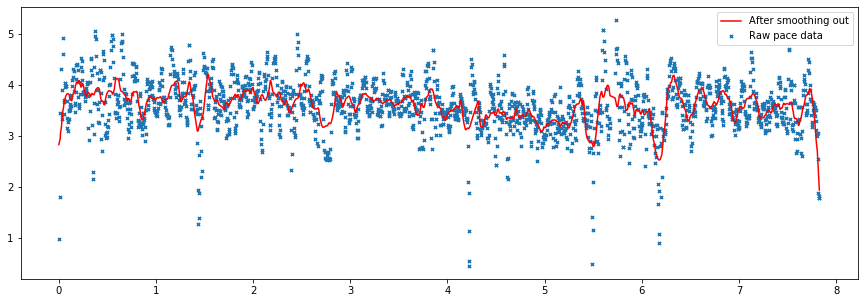

In [10]:
plotting.smoothed_plot(run_smooth, 'pace')

For the altitude, we are now going to recalcuate the vertical gain/loss using the smoothed-out elevation. However, even this isn't enough to get close to Strava's estimates, so we introduce an additional threshold parameter (epsilon) for the elevation difference for two adjacent points - if it is smaller than that, we will not add it to the total.

The precise value of epsilon will later be gauged by comparing the results obtained from the various gpx files with the total elevation per activity we can get from Strava's aggregated data. 

In [11]:
run_adjust = f.adjust_vertical(run_smooth, epsilon = 0.09)

print(f"New total vertical gain: {round(max(run_adjust['vertical_gain_smooth']),2)}m, " 
      +f"new total vertical loss: {round(max(run_adjust['vertical_loss_smooth']),2)}m.")

New total vertical gain: 19.47m, new total vertical loss: 17.43m.


This looks much better! 

To continue, we will now throw away some information. Even this short run consisted of almost 2000 data points, much more than we could reasonably need. We therefore 'coarse grain' the above data frame and summarize the information by kilometer. Some things to note:

- we keep a column for vertical gain/loss as well as their 'smoothed-out' variant for later comparisons
- there are two entries for `min_per_km`, one is estimated from the (average) pace, the other from the elapsed time (`min_per_km_2`). The latter is more accurate for races, the former closer to normal activities (where the athlete might interrupt and resume manually, or Strava uses autostop)

In [14]:
coarse_df = format_gpx.coarse_grain_activity(run_adjust)
coarse_df.head()

,distance,alt_max,alt_min,pace,hour_of_day,elapsed_time,vertical_gain,vertical_loss,vertical_gain_smooth,vertical_loss_smooth,min_per_km,min_per_km_2
km,,,,,,,,,,,,
1,1.0,532.7,521.9,3.78,19,00:04:38,15.8,10.6,11.6,6.0,00:04:25,00:04:38
2,2.0,531.5,524.8,3.75,19,00:09:10,21.0,21.7,11.7,6.0,00:04:27,00:04:32
3,3.0,527.0,522.7,3.68,19,00:13:50,28.4,27.7,11.7,6.0,00:04:32,00:04:40
4,4.0,527.1,524.2,3.66,19,00:18:26,36.3,34.8,11.7,7.4,00:04:33,00:04:36
5,5.0,528.0,526.1,3.39,19,00:23:40,41.3,40.4,11.7,7.4,00:04:55,00:05:14


How does this compare, once again, to Strava's data? 

![image](data\splits_screenshot.png)

Note that neither estimate is perfect, and it's hard to say from there what exactly Strava is using. The last minute is very much off for the second estimate because the kilometer was not finished, but we won't bother fixing this here.

Finally, we can save the last data frame to a file.

In [13]:
coarse_df.to_csv(f'data/{file_id}_coarse.csv')